url :

https://newsroom.fluor.com/news-releases/all-news-releases/default.aspx

In [1]:
#libraries
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd,requests,bs4,re,time,io,pytesseract,easyocr,random,textstat,urllib.request
from pdfminer.high_level import extract_text
from PIL import Image
from pathlib import Path
from pdf2image import convert_from_path
from goose3 import Goose
from datetime import datetime
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

reader = easyocr.Reader(['en'])

import warnings
warnings.filterwarnings("ignore")

%autosave 1

Autosaving every 1 seconds


In [2]:
SITE_NAME='FLUOR'

DOMAIN = "https://newsroom.fluor.com"

SITE_LINK = "https://newsroom.fluor.com/news-releases/all-news-releases/default.aspx"

In [3]:
#functions
def parse_webpage_bs(search_url):
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0"}
    try:
        site_request = requests.get(search_url, headers=headers, timeout=10)
    except requests.exceptions.RequestException as e:
        print(e)
        site_request = None
    if site_request != None and site_request.status_code==200:
        site_soup = bs4.BeautifulSoup(site_request.content, "lxml")
    else:
        site_soup = None
    return site_soup

def remove_esc_chars(string):
    review = re.sub('''[^a-zA-Z0-9!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]''', ' ',string)
    review = review.split()
    review = ' '.join(review)
    return review

def get_text(link): 
    try:
        soup = parse_webpage_bs(link)
        if soup!= None:
            article = soup.find('div',{'class' :'module_body'}).text
        text = remove_esc_chars(article)
    except:
        g = Goose()
        article_extract = g.extract(url=link)
        article = remove_esc_chars(article_extract.cleaned_text)
        meta_data = remove_esc_chars(article_extract.meta_description)
        whole_data = meta_data+article
        text = whole_data.strip()

        if textstat.lexicon_count(text, removepunct=True) < 5:
            try:
                response = requests.get(link)
                text = remove_esc_chars(extract_text(io.BytesIO(response.content)))

                if textstat.lexicon_count(text, removepunct=True) < 5:
                    texts = ""
                    r = requests.get(link)
                    filename = Path('temp.pdf')
                    filename.write_bytes(r.content)

                    pages = convert_from_path('temp.pdf', 500)
                    for x in pages:
                        x.save("temp.jpg")
                        output = reader.readtext("temp.jpg")
                        for o in output:
                            texts += o[1]

                    text = remove_esc_chars(texts)

                    if textstat.lexicon_count(text, removepunct=True) < 5:
                        texts = ""
                        soup = parse_webpage_bs(link)
                        if soup!= None:
                            ps = soup.findAll('p')
                            for p in ps:
                                texts+= p.text

                        text = remove_esc_chars(texts)
            except:
                text = ""
    
    return text

def parse_webpage_api(search_url):
    try:
        req = requests.get(search_url)
        data = req.json()
        return data
    except:
        return []

In [7]:
#get data
article_list = []

pagination = datetime.today().year
last_year = 1996

while pagination >= last_year:
    #getting api according to pagination
    api = f"https://newsroom.fluor.com/feed/PressRelease.svc/GetPressReleaseList?apiKey=BF185719B0464B3CB809D23926182246&LanguageId=1&bodyType=0&pressReleaseDateFilter=3&categoryId=1cb807d2-208f-4bc3-9133-6a9ad45ac3b0&pageSize=-1&pageNumber=0&tagList=&includeTags=true&year={pagination}&excludeSelection=1"
    data = parse_webpage_api(api)
    
    #getting the data if there is data 
    if data != None:
        elements = data['GetPressReleaseListResult']
        
        #published_date,title,text,link,thumbnail,author
        for element in tqdm(elements[:2],desc=f"Getting data for year {pagination}"):
            published_date = element['PressReleaseDate'].split(" ")[0].strip()
            title = element['Headline'].strip()
            link = DOMAIN +  element['LinkToDetailPage'].strip()
            try:
                thumbnail = element['MediaFiles'][0]['Path'].strip()
            except:
                thumbnail = "https://s1.q4cdn.com/746290702/files/doc_multimedia/FLR-full.jpg"
            author = SITE_NAME 
            text = get_text(link)
            article = (published_date,title,text,link,thumbnail,author)
            article_list.append(article)
            print(published_date,title)
    
    pagination -=1
    

Getting data for year 2022:   0%|          | 0/2 [00:00<?, ?it/s]

06/22/2022 Fluor Awarded Engineering, Procurement and Construction Management Services Contract for Iluka’s Eneabba Rare Earths Refinery in Australia
06/08/2022 Fluor Selected for Interstate 35 Capital Express South Project in Austin, Texas


Getting data for year 2021:   0%|          | 0/2 [00:00<?, ?it/s]

12/16/2021 Fluor-Led JV Completes A9 Roadways Project in Amsterdam
12/14/2021 Fluor-Backed NuScale Power Signs Agreement to Accelerate Small Modular Reactor Commercialization


Getting data for year 2020:   0%|          | 0/2 [00:00<?, ?it/s]

12/15/2020 Stork Awarded Maintenance Contract by Sitech in the Netherlands
12/10/2020 Fluor Reports Third Quarter 2020 Results


Getting data for year 2019:   0%|          | 0/2 [00:00<?, ?it/s]

12/24/2019 COOEC-Fluor Completes Module Program for KIPIC Al-Zour Project in Kuwait
12/23/2019 Fluor-Led Joint Venture Opens Loop 202 South Mountain Freeway Project


Getting data for year 2018:   0%|          | 0/2 [00:00<?, ?it/s]

12/12/2018 Fluor Set to Modernize Red & Purple Rail Lines in Chicago
11/20/2018 Fluor Selected for Lithium and Boron Mine Project in Nevada


Getting data for year 2017:   0%|          | 0/2 [00:00<?, ?it/s]

12/28/2017 Power on the Way to Major Urban Areas as Fluor Completes Work on Priority Lines in Puerto Rico
12/21/2017 Fluor Selected as FEMA’s Zone 1 Contractor for its Technical Assistance Contracts IV


Getting data for year 2016:   0%|          | 0/2 [00:00<?, ?it/s]

12/20/2016 Fluor to Design and Build $2 Billion Diabetes API Manufacturing Facility for Novo Nordisk in North Carolina
12/15/2016 Fluor-Led Team Completes Tappan Zee Bridge Towers


Getting data for year 2015:   0%|          | 0/2 [00:00<?, ?it/s]

12/07/2015 Fluor Agrees to Acquire Stork Holding B.V., a Global Industrial Services Company
12/03/2015 Fluor Garners UK Binding Corporate Rules Approval for Secure Employee and Client Data


Getting data for year 2014:   0%|          | 0/2 [00:00<?, ?it/s]

12/19/2014 AMECO Celebrates Grand Opening of its New Global Headquarters
12/16/2014 Fluor Begins Work on ExxonMobil Antwerp Refinery Delayed Coker Project in Belgium


Getting data for year 2013:   0%|          | 0/2 [00:00<?, ?it/s]

12/30/2013 Fluor to Provide Consulting Services for Kuwait Oil Company Projects
12/12/2013 Fluor’s NuScale Power Awarded U.S. DOE Funding to Advance Nuclear Small Modular Reactor Technology


Getting data for year 2012:   0%|          | 0/2 [00:00<?, ?it/s]

12/17/2012 Fluor Team Selected for Tappan Zee Bridge Replacement in New York
12/13/2012 Fluor’s John Hopkins Assumes Role of Chairman and CEO of NuScale Power


Getting data for year 2011:   0%|          | 0/2 [00:00<?, ?it/s]

12/16/2011 Fluor Awarded Base Operations Support Contract by U.S. Navy for Jacksonville-Area Bases
12/13/2011 Fluor Signs MOU with Clean Line Energy for 800-Mile Transmission Line


Getting data for year 2010:   0%|          | 0/2 [00:00<?, ?it/s]

12/20/2010 Retired Army Lieutenant General Richard A. Hack Joins Fluor’s Government Group
12/17/2010 Fluor Team Achieves Financial Close on Windsor-Essex Parkway


Getting data for year 2009:   0%|          | 0/2 [00:00<?, ?it/s]

12/09/2009 Utah DOT Selects Fluor-Led Team for $1.1 Billion Major Expansion of I-15 Corridor
12/01/2009 National Safety Council Selects AMECO for Best Safety Performance


Getting data for year 2008:   0%|          | 0/2 [00:00<?, ?it/s]

12/15/2008 Fluor Honored by Hart Energy
12/04/2008 Fluor Forms New Business Unit to Focus on Offshore Market


Getting data for year 2007:   0%|          | 0/2 [00:00<?, ?it/s]

12/20/2007 Fluor-Transurban Consortium and VDOT Sign Contract to Design, Build and Operate I-495 HOT Lanes
11/14/2007 Fluor to Present at the Bear Stearns Annual Commodities and Capital Goods Conference


Getting data for year 2006:   0%|          | 0/2 [00:00<?, ?it/s]

12/11/2006 Fluor Opens Northeast Region Office, Employs 200 Professionals
12/07/2006 AMECO Celebrates 15 Million Safe Work Hours


Getting data for year 2005:   0%|          | 0/2 [00:00<?, ?it/s]

12/14/2005 Fluor Awarded Front-end Engineering Contract for Louisiana Refinery Expansion
11/28/2005 Fluor to Present at the Bear Stearns Annual Commodities and Capital Goods Conference


Getting data for year 2004:   0%|          | 0/2 [00:00<?, ?it/s]

12/30/2004 Fluor Corporation Exercises Rights Under Convertible Notes Indenture
12/22/2004 Fluor Selected By Sasol to Upgrade South African Refinery


Getting data for year 2003:   0%|          | 0/2 [00:00<?, ?it/s]

12/18/2003 Ishikawajima-Harima Heavy Industries Co. Ltd. & ICA Fluor Consortium Awarded First LNG Terminal in Mexico
12/15/2003 Fluor and Lukoil Neftegazstroy to Build Russian Oil Products Export Terminal


Getting data for year 2002:   0%|          | 0/2 [00:00<?, ?it/s]

12/16/2002 ICA Fluor Daniel Signs Contract to Build 498 MW Power Plant for Iberdrola
12/13/2002 Fluor Celebrates 50 Years of Community Service


Getting data for year 2001:   0%|          | 0/2 [00:00<?, ?it/s]

12/17/2001 Fluor Appoints Alan Boeckmann Chairman and Chief Executive Officer
12/11/2001 Fluor Selected by Kennecott to Provide Maintenance Services at Utah Smelter


Getting data for year 2000:   0%|          | 0/2 [00:00<?, ?it/s]

12/28/2000 Fluor Provides Guidance on 'Stub' Period and First Quarter
12/08/2000 'New' Fluor Corporation Announces Dividend Schedule for 2001


Getting data for year 1999:   0%|          | 0/2 [00:00<?, ?it/s]

12/31/1999 Fluor Corp. Media Relations Officials Available To Comment on Y2K Status Throughout New Year's Weekend
12/08/1999 Fluor Corp. Raises Quarterly Dividend, Signals Change in Long Term Strategy


Getting data for year 1998:   0%|          | 0/2 [00:00<?, ?it/s]

12/16/1998 American Equipment Company Acquires Full Interest in Mexico's Maquinaria Panamericana, S.A. de C.V.
12/10/1998 Fluor Corporation Appoints Senior Vice President of Human Resources


Getting data for year 1997:   0%|          | 0/2 [00:00<?, ?it/s]

12/15/1997 Fluor Corporation Announces Strategic Alternatives Analysis
12/10/1997 Fluor Corporation Board Declares Quarterly Dividend


Getting data for year 1996:   0%|          | 0/2 [00:00<?, ?it/s]

12/20/1996 Fluor Announces SEC Filing
12/19/1996 Fluor Daniel And Mitsubishi Heavy Industries Win First Major LNG Contract


In [14]:
temp_df = pd.DataFrame(article_list,columns=['date','title','article','url','thumbnail','author'])
temp_df.head()

,date,title,article,url,thumbnail,author
0,06/22/2022,"Fluor Awarded Engineering, Procurement and Con...","IRVING, Texas--(BUSINESS WIRE)-- Fluor Corpora...",https://newsroom.fluor.com/news-releases/news-...,https://s1.q4cdn.com/746290702/files/doc_multi...,FLUOR
1,06/08/2022,Fluor Selected for Interstate 35 Capital Expre...,"IRVING, Texas--(BUSINESS WIRE)-- Fluor Corpora...",https://newsroom.fluor.com/news-releases/news-...,https://s1.q4cdn.com/746290702/files/doc_multi...,FLUOR
2,12/16/2021,Fluor-Led JV Completes A9 Roadways Project in ...,"IRVING, Texas & AMSTERDAM--(BUSINESS WIRE)-- F...",https://newsroom.fluor.com/news-releases/news-...,https://s1.q4cdn.com/746290702/files/doc_multi...,FLUOR
3,12/14/2021,Fluor-Backed NuScale Power Signs Agreement to ...,- Merger agreement with Spring Valley Acquisit...,https://newsroom.fluor.com/news-releases/news-...,https://s1.q4cdn.com/746290702/files/doc_multi...,FLUOR
4,12/15/2020,Stork Awarded Maintenance Contract by Sitech i...,"IRVING, Texas & UTRECHT, the Netherlands--(BUS...",https://newsroom.fluor.com/news-releases/news-...,https://s1.q4cdn.com/746290702/files/doc_multi...,FLUOR


12/21/2017 Fluor Selected as FEMA’s Zone 1 Contractor for its Technical Assistance Contracts IV

FLUOR https://newsroom.fluor.com/news-releases/news-details/2017/Fluor-Selected-as-FEMAs-Zone-1-Contractor-for-its-Technical-Assistance-Contracts-IV/default.aspx


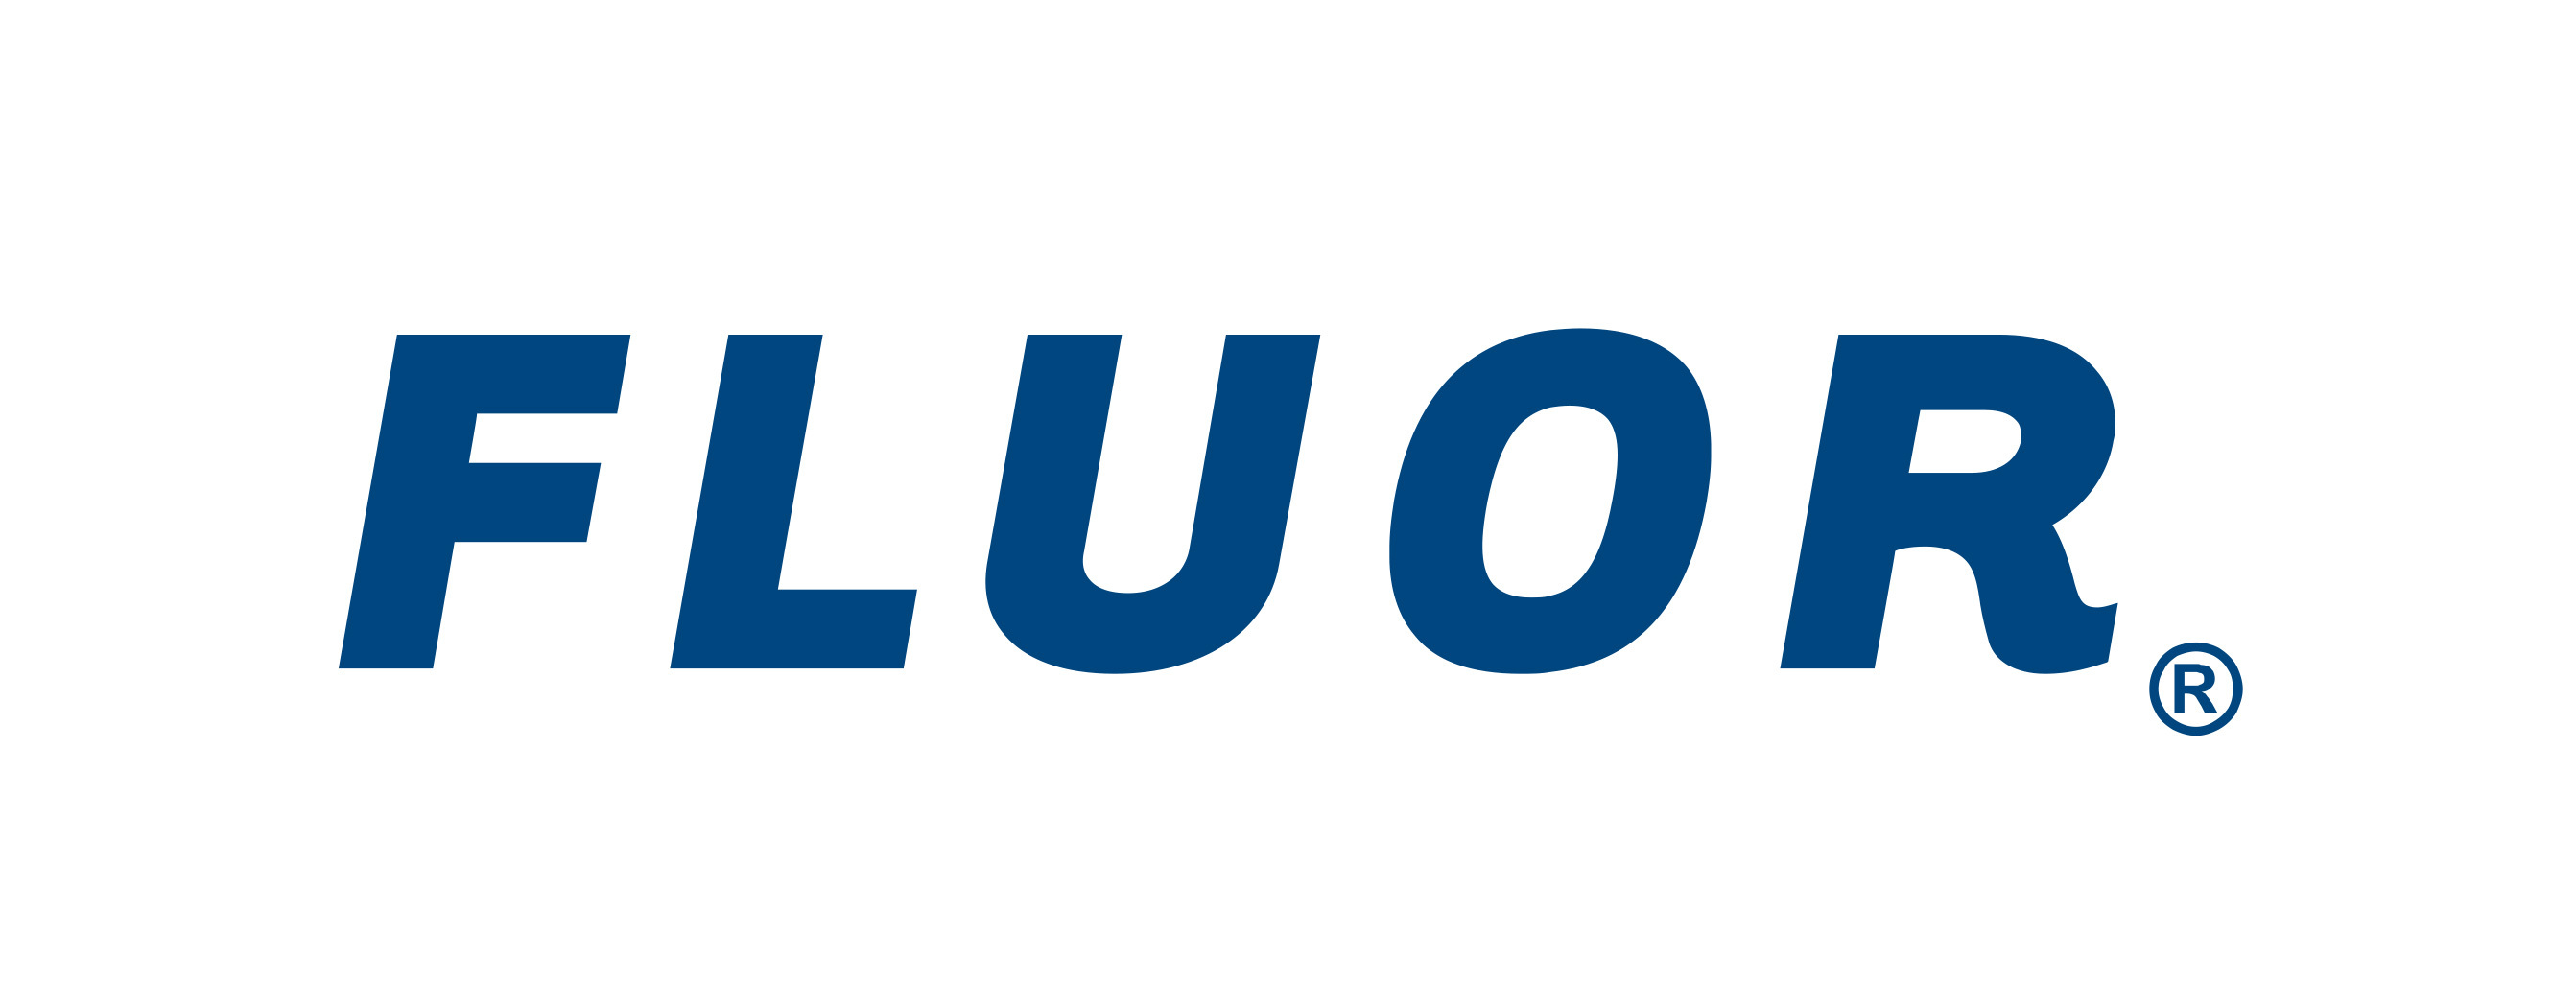


Fluor Corporation (NYSE: FLR) announced today that the Federal Emergency Management Agency (FEMA) has selected Fluor to provide recovery services to Zone 1 of the Public Assistance Division s Technical Assistance Contracts IV (PA-TAC IV). This is part of a new approach by FEMA to align PA-TAC IV contractors with one of three geographical zones to more effectively provide resource support. The Fluor contract includes the zone that extends from along the Atlantic Coast to the Gulf Coast including 19 states and the District of Columbia. The contract has a five-year period of performance and is valued at $610 million. From tornadoes in Kansas, river floods in North Dakota, earthquakes and flooding in California and hurricanes all along the U.S. Gulf Coast, Fluor has worked closely with FEMA for 20 years to provide assistance in disaster-stricken locations, said Tom D Agostino, president of Fluor Government Group. Today, Fluor is on the ground supporting FEMA in Texas and Florida with reco

In [15]:
def see_data(iloc_no=random.randint(0,len(temp_df))-1):
    print(temp_df.iloc[iloc_no]['date'],temp_df.iloc[iloc_no]['title'])
    print(f"\n{temp_df.iloc[iloc_no]['author']} {temp_df.iloc[iloc_no]['url']}")
    urllib.request.urlretrieve(temp_df.iloc[iloc_no]['thumbnail'], "temp.jpg")
    display(Image.open("temp.jpg"))
    print(f"\n{temp_df.iloc[iloc_no]['article']}")

see_data()

In [16]:
#to csv
temp_df.to_csv(f'{SITE_NAME} news.csv',index = False)

#to json
temp_df.to_json(f'{SITE_NAME} news.json')

In [17]:
#to get rid of unwanteed trash created by the model use 
def remove_trash():
    try:
        try:
            os.remove("temp.pdf")
        except:
            pass
        os.remove("temp.jpg")
        print("Trash removed successfully")
    except:
        print("No trash found")

remove_trash()

Trash removed successfully
